# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [5]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: так как в y_random содержится метод predict_proba, который возвращает вероятности классов

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [39]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


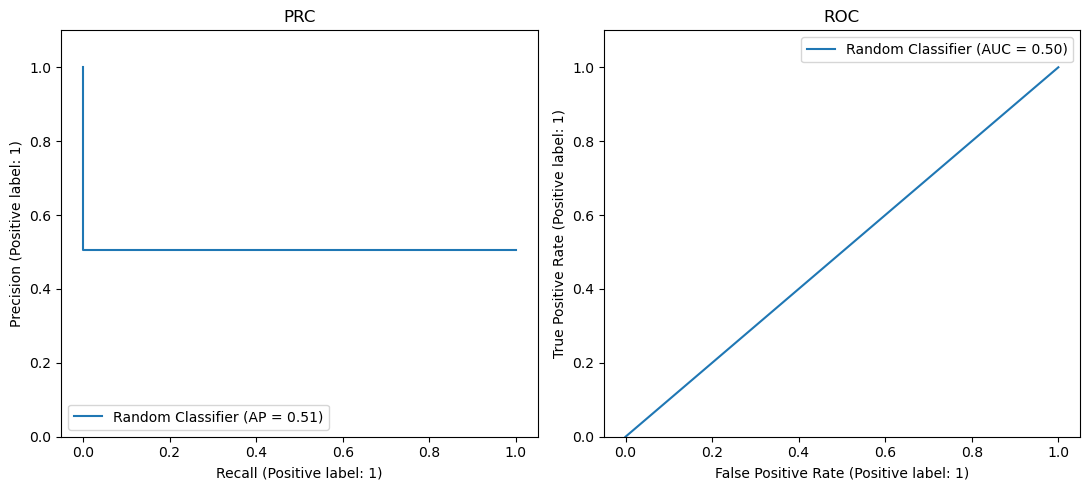

In [9]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [11]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [13]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

svm = LinearSVC()
param_grid = {'C': [0.01, 0.1, 1, 10, 100]} 
grid_search = GridSearchCV(svm, param_grid, cv=4,  scoring='average_precision')
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_
print(f"Best C: {best_C['C']}")

/Users/dianalubnevskaya/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/dianalubnevskaya/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/dianalubnevskaya/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/dianalubnevskaya/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warnin

Best C: 10


/Users/dianalubnevskaya/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

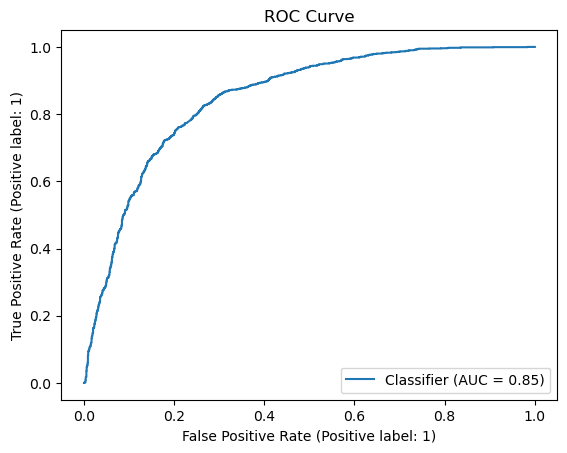

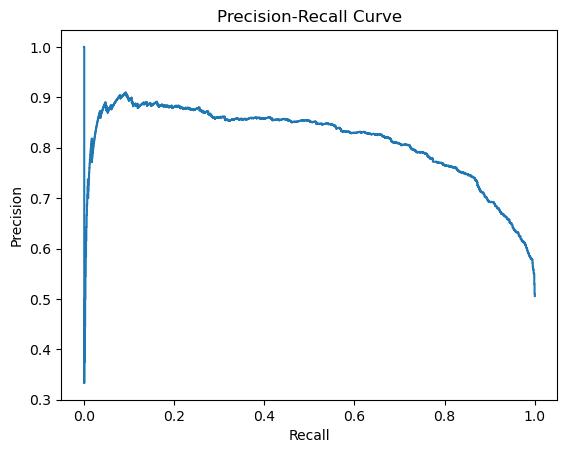

AUC-ROC: 0.848
AUC-PR: 0.815


In [15]:
from sklearn.svm import SVC

best_svm = SVC(kernel='linear', C=best_C['C'], probability=True)
best_svm.fit(X_train, y_train)
y_scores = best_svm.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_scores)
RocCurveDisplay.from_predictions(y_test, y_scores)
plt.title(f'ROC Curve')
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title(f'Precision-Recall Curve')
plt.show()

print(f"AUC-ROC: {roc_auc:.3f}")
print(f"AUC-PR: {pr_auc:.3f}")

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

1) PR при увеличении порога падает, т.к не берем неуверенных
 
ROC TP уменьшается, т.к. если брать всех, то всех положительных точно возьмем, но и отрицательных тоже всех, значит FP тоже уменьшается

2) PR не монотонный, потому что, скорее всего, при малых порогах меняется нерегулярно
 
ROC монотонный, т.к. доли уменьшаются пропорционально

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [17]:
df_metrics.loc['LinearSVC'] = [
      average_precision_score(y_test, y_scores),
      roc_auc_score(y_test, y_scores),
      grid_search.best_params_['C']
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0
LinearSVC,0.815202,0.847871,10.0


стало явно лучше

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [19]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(penalty='l2', solver='liblinear')
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(log_reg, param_grid, cv=4, scoring='average_precision')
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_
print(f"Best C: {best_C['C']}")

Best C: 100


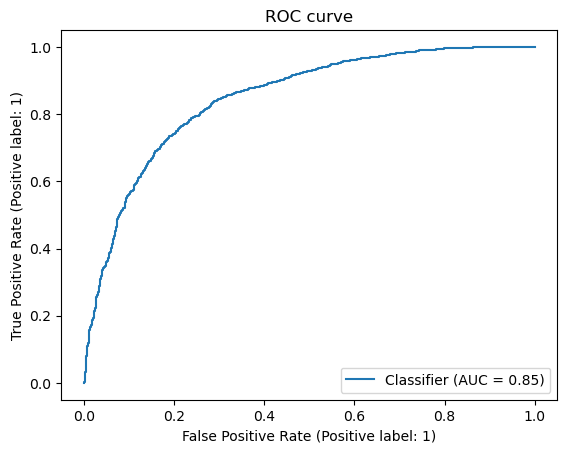

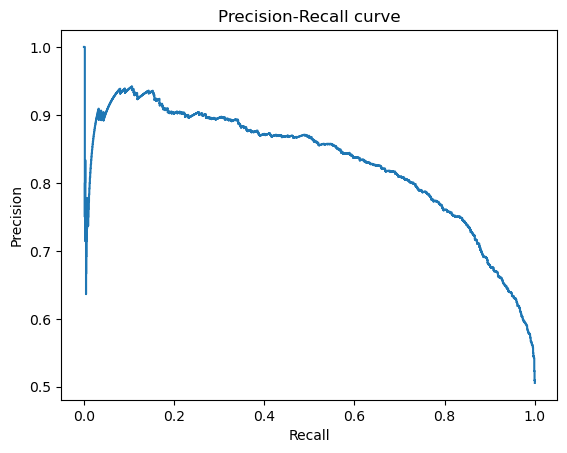

AUC-ROC: 0.848
AUC-PR: 0.829


In [21]:
best_log_reg = LogisticRegression(penalty='l2', C=best_C['C'], solver='liblinear')
best_log_reg.fit(X_train, y_train)
y_scores = best_log_reg.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_scores)
RocCurveDisplay.from_predictions(y_test, y_scores)
plt.title(f'ROC curve')
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title(f'Precision-Recall curve')
plt.show()

print(f"AUC-ROC: {roc_auc:.3f}")
print(f"AUC-PR: {pr_auc:.3f}")

In [23]:
df_metrics.loc['LogReg'] = [
      average_precision_score(y_test, y_scores),
      roc_auc_score(y_test, y_scores),
      grid_search.best_params_['C']
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0
LinearSVC,0.815202,0.847871,10.0
LogReg,0.829384,0.847879,100.0


AUC-PR стала немного больше, а ROC-AUC совсем чуть-чуть снизилась

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

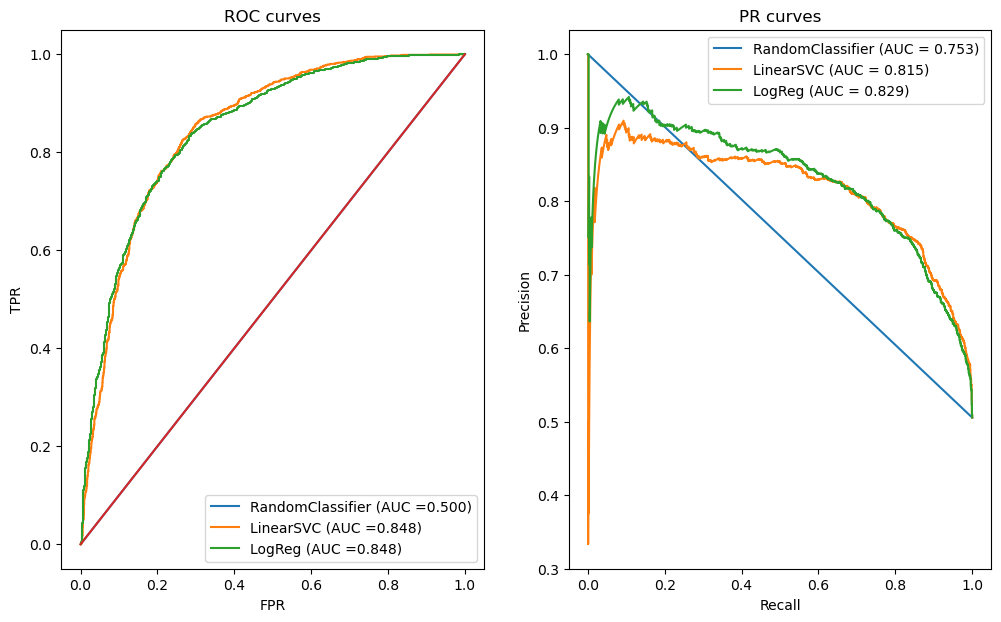

In [25]:
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
classifiers = [random_classifier, best_svm, best_log_reg]
classifiers_names = ['RandomClassifier', 'LinearSVC', 'LogReg']

for i, x in enumerate(classifiers):
    name = classifiers_names[i]
    model = x.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,1]

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    ax[0].plot(fpr, tpr, label=f'{name} (AUC ={roc_auc:.3f})')

    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    ax[1].plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})')
ax[0].plot([0, 1], [0, 1])
ax[0].legend()
ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')
ax[0].set_title('ROC curves')
ax[1].legend()
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('PR curves')
plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** ROC-AUC практически не отличается у лог регрессии и метода опорных векторов, но очевидно отличается от случайного классификатора. AUC-PR немного отличается, у лог регрессии немного выше, это может быть связано с тем, что в лог регрессии калибруются вероятности (ну и опять же оба значения отличаются от случайного классификатора)

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [27]:
X, y = make_classification(n_samples=10000,n_features=2, n_informative=2, n_redundant=0, n_classes=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

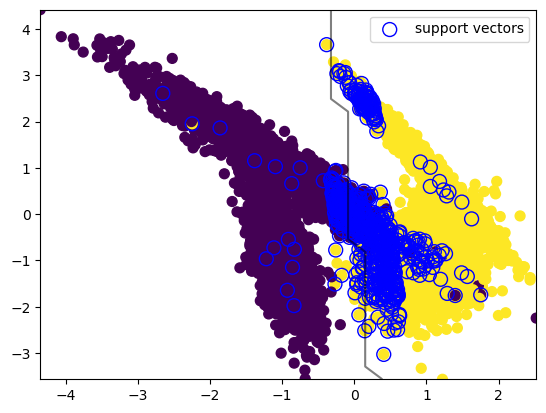

In [29]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.predict(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X, y, model)
plt.show()

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** синие, так как они находятся ближе всего к разделяющей прямой

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [31]:
model_log = LogisticRegression()
model_log.fit(X_train, y_train)

LogisticRegression()

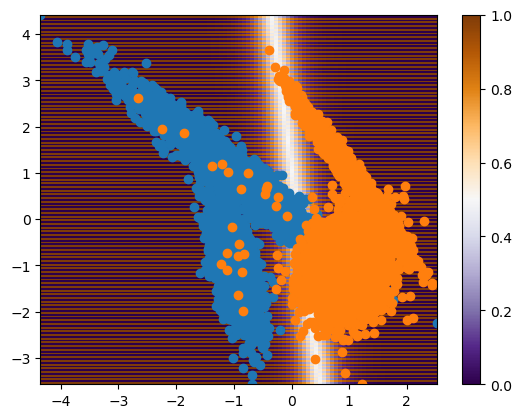

In [33]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(X[y == 0, 0], X[y == 0, 1],  label='Класс 0')
    plt.scatter(X[y == 1, 0], X[y == 1, 1],  label='Класс 1')
    plt.colorbar(image)

plot_logreg_2D(X, y, model_log)
plt.show()

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** область, где модель не уверена, это светлая линия на графике. Обосновать это можно тем, что p = 0.5 означает, что (w, x_i) = 0, то есть как раз и есть прямая.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

Ошибки:
1) когда добавляем bin_middle_points, надо добавлять (l+r)/2
2) в bin_real_ratios надо добавлять среднее, а не минимум

In [35]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

/Users/dianalubnevskaya/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


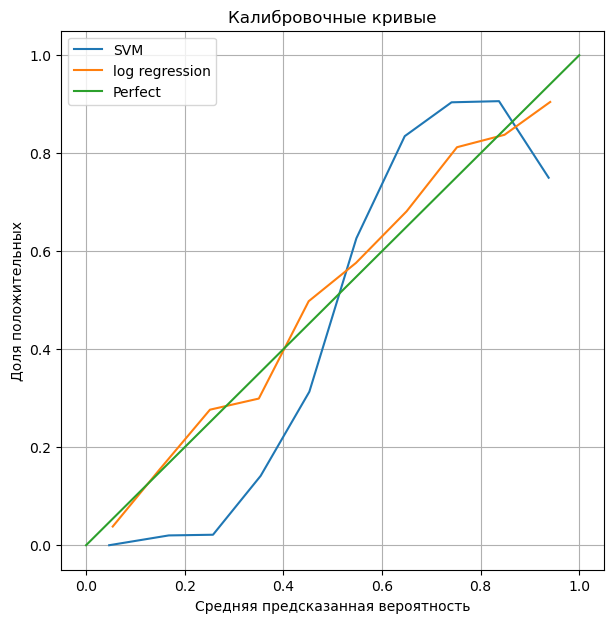

In [37]:
from sklearn.calibration import calibration_curve

X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
log_reg = LogisticRegression(max_iter=100000, C=100)
log_reg.fit(X_train, y_train)
svc = LinearSVC(max_iter=100000, C=10)
svc.fit(X_train, y_train)
log_reg_pred = log_reg.decision_function(X_test)
svc_pred = svc.decision_function(X_test)
log_reg_pred = log_reg.predict_proba(X_test)[:, 1]
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())

plt.figure(figsize=(7, 7))
svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred, n_bins=10)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, log_reg_pred, n_bins=10)
plt.plot(svc_pred_prob, svc_true_prob, label='SVM')
plt.plot(lr_pred_prob, lr_true_prob, label='log regression')
plt.plot([0, 1], [0, 1], label='Perfect')
plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Доля положительных')
plt.title('Калибровочные кривые')
plt.legend()
plt.grid()
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** для лог регрессии откалибровано хорошо, для SVM не совсем, так как ее кривая сильнее отклоняется от диагонали.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [39]:
from sklearn.metrics import log_loss, brier_score_loss

logloss_svm = log_loss(y_test, svc_pred)
brier_svm = brier_score_loss(y_test, svc_pred)
logloss_lr = log_loss(y_test, log_reg_pred)
brier_lr = brier_score_loss(y_test, log_reg_pred)
print(f'LogLoss для SVM: {logloss_svm}')
print(f'LogLoss для лог регрессии: {logloss_lr}')
print(f'BrierScore для SVM: {brier_svm}')
print(f'BrierScore для лог регрессии: {brier_lr}')

LogLoss для SVM: 0.5545839565911472
LogLoss для лог регрессии: 0.48585381100808656
BrierScore для SVM: 0.18448812711201482
BrierScore для лог регрессии: 0.15858116095534455


Как мы видим, ошибка на лог регрессии меньше (действительно тонко)

Изучите распределение ответов классификаторов при помощи гистограмм

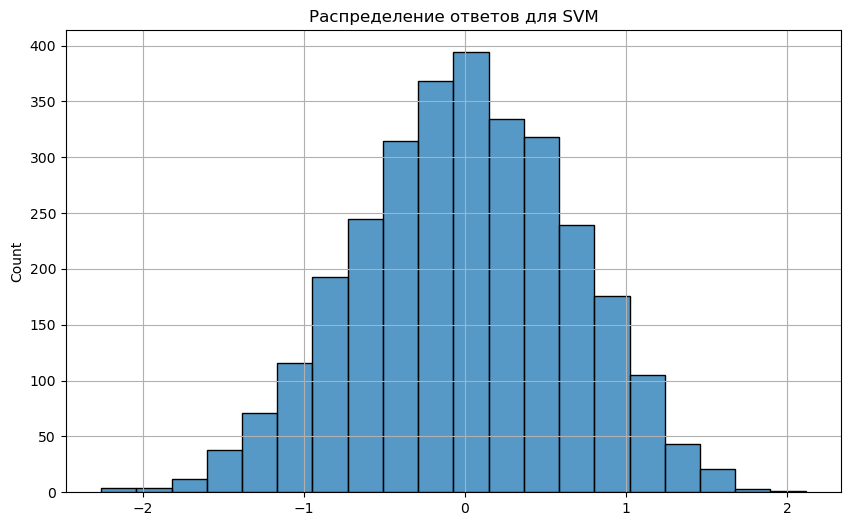

In [41]:
import seaborn as sns

svc_pred = svc.decision_function(X_test)
plt.figure(figsize=(10, 6))
sns.histplot(svc_pred, bins=20)
plt.title('Распределение ответов для SVM')
plt.grid()
plt.show()

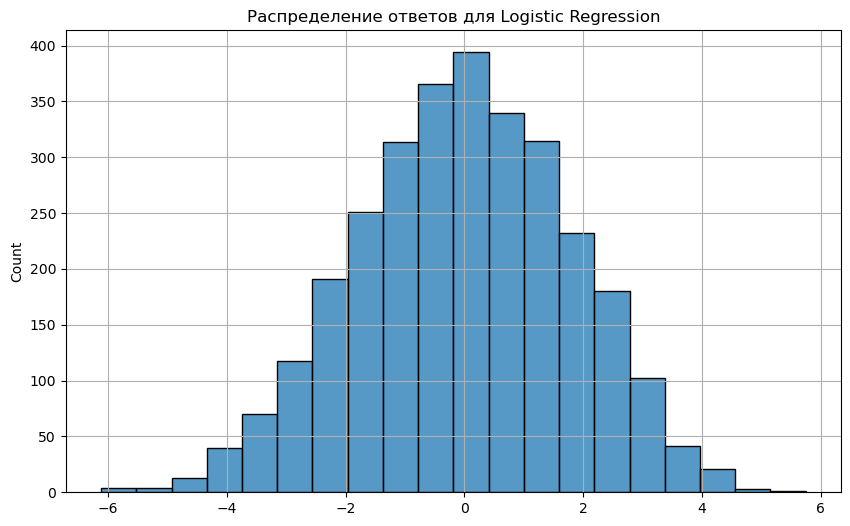

In [43]:
log_reg_pred = log_reg.decision_function(X_test)

plt.figure(figsize=(10, 6))
sns.histplot(log_reg_pred, bins=20)
plt.title('Распределение ответов для Logistic Regression')
plt.grid()
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** В лог регрессии разброс больше, потому что логистическую регрессию мы изначально обучаем на предсказании вероятностей, а SVM проводит разделяющую гиперплоскость таким образом, чтобы максимизировать минимальный отступ.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

/Users/dianalubnevskaya/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/dianalubnevskaya/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/dianalubnevskaya/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/dianalubnevskaya/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warnin

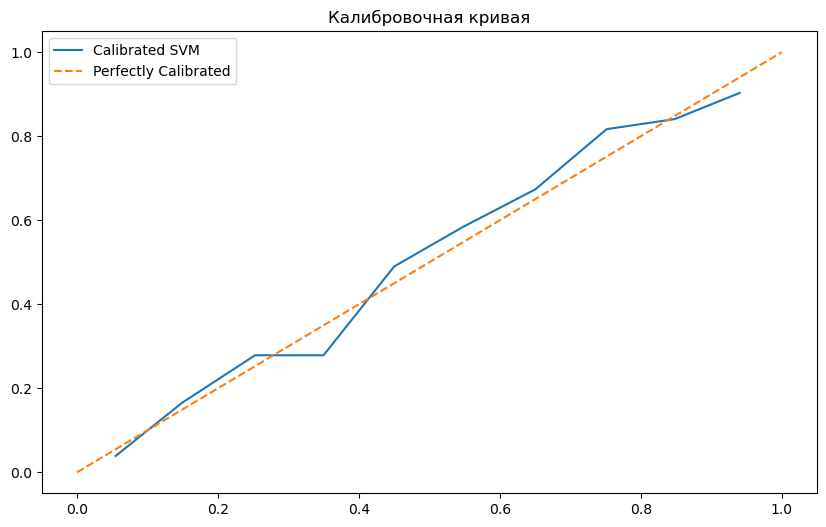

In [45]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_svm = CalibratedClassifierCV(svc, method='sigmoid', cv=4)
calibrated_svm.fit(X_train, y_train)
y_scores = calibrated_svm.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, y_scores, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, label='Calibrated SVM')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Калибровочная кривая')
plt.legend()
plt.show()

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** да, стало лучше, ближе к идеально откалиброванной прямой

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
# your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [106]:
pip install kagglehub

  Obtaining dependency information for kagglehub from https://files.pythonhosted.org/packages/3c/74/10ea2151b11f8591f82d39c70c1dcc43d0160ba41f8ddb644eb1f5eac348/kagglehub-0.3.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [47]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [88]:
# Прочитаем датасет
df = pd.read_csv(path)
# Заменим пропуски категориальных переменных
categorical_columns = df[['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']]
for col in categorical_columns:
    df[col].fillna('undefined', inplace=True)

# Отделим X и y
X = df.drop(['Purchased Bike', 'ID'], axis=1)
y = (df['Purchased Bike'] == 'Yes').astype('int64')

# Разделим на категориальные признаки и числовые
X_numerical = ['Income', 'Children', 'Cars', 'Age']
X_categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']

In [55]:
df

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,undefined,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23731,Married,Male,60000.0,2.0,High School,Professional,Yes,2.0,2-5 Miles,North America,54.0,Yes
996,28672,Single,Male,70000.0,4.0,Graduate Degree,Professional,Yes,0.0,2-5 Miles,North America,35.0,Yes
997,11809,Married,undefined,60000.0,2.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,North America,38.0,Yes
998,19664,Single,Male,100000.0,3.0,Bachelors,Management,No,3.0,1-2 Miles,North America,38.0,No


В начале поработаем только с категориальными признаками

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [92]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
import time

log_reg = LogisticRegression()
column_transformer = ColumnTransformer([
    ("ordencoder", OrdinalEncoder(), X_categorical)
])

pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('logistic', log_reg),
])
start_time = time.time()
pipeline.fit(X_train,y_train)
training_time = time.time() - start_time
y_scores = pipeline.predict_proba(X_test)[:, 1]
pr_auc = average_precision_score(y_test, y_scores)

print(f"AUC-PR: {pr_auc:.3f}")
print(f"Training time: {training_time:.3f} seconds")

AUC-PR: 0.588
Training time: 0.050 seconds


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [94]:
from sklearn.preprocessing import OneHotEncoder

log_reg = LogisticRegression()
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), X_categorical)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('logistic', log_reg),
])
start_time = time.time()
pipeline.fit(X_train,y_train)
training_time = time.time() - start_time
y_scores = pipeline.predict_proba(X_test)[:, 1]
pr_auc = average_precision_score(y_test, y_scores)

print(f"AUC-PR: {pr_auc:.3f}")
print(f"Training time: {training_time:.3f} seconds")

AUC-PR: 0.667
Training time: 0.079 seconds


Значение AUC-PR стало лучше, однако немного увеличилось время

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [98]:
!pip install category_encoders

python(52369) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Obtaining dependency information for category_encoders from https://files.pythonhosted.org/packages/98/47/598b4bf0ccf6f02915e71bdd23fe846a27adc2d3ba734f2ba5215d8e44f5/category_encoders-2.6.4-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 1.1 MB/s eta 0:00:00a 0:00:01


In [100]:
from category_encoders.target_encoder import TargetEncoder

log_reg = LogisticRegression()
column_transformer = ColumnTransformer([
    ('te', TargetEncoder(smoothing=1), X_categorical)
])

pipeline = Pipeline(steps=[
    ('transform', column_transformer),
    ('logistic', log_reg),
])
start_time = time.time()
pipeline.fit(X_train,y_train)
training_time = time.time() - start_time
y_scores = pipeline.predict_proba(X_test)[:, 1]
pr_auc = average_precision_score(y_test, y_scores)

print(f"AUC-PR: {pr_auc:.3f}")
print(f"Training time: {training_time:.3f} seconds")

AUC-PR: 0.680
Training time: 0.196 seconds


качество стало еще лучше, однако времени требуется больше

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [75]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.mean_target_values = {}

    def fit(self, X, y):
        for feature in self.categorical_features:
            self.mean_target_values[feature] = X.join(y).groupby(feature)[y.name].mean()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.categorical_features:
            X_transformed[feature] = X_transformed[feature].map(self.mean_target_values[feature])
        return X_transformed

    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [107]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, noise_level=0.01):
        self.categorical_features = categorical_features
        self.noise_level = noise_level
        self.mean_targets = {}

    def fit(self, X, y):
        data = pd.concat([X, y], axis=1)
        for feature in self.categorical_features:
            mean_target = data.groupby(feature)['Purchased Bike'].mean()
            self.mean_targets[feature] = mean_target
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.categorical_features:
            mean_target = self.mean_targets[feature]
            noise = np.random.normal(0, self.noise_level, size=len(X))
            X_transformed[feature] = X[feature].map(mean_target) + noise
        return X_transformed

pipeline = Pipeline(steps=[
    ('transform', MeanTargetTransformer(X_categorical)),
    ('logistic', log_reg),
])
start_time = time.time()
pipeline.fit(X_train[X_categorical],y_train)
training_time = time.time() - start_time

y_scores = pipeline.predict_proba(X_test[X_categorical])[:, 1]
pr_auc = average_precision_score(y_test, y_scores)
print(f"AUC-PR: {pr_auc:.3f}")
print(f"Training time: {training_time:.3f} seconds")

AUC-PR: 0.656
Training time: 0.460 seconds


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Добавление шума не помогло, даже сделало хуже, так как, возможно, шум исказил данные, в результате чего модель стала работать менее корректно

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global{\_}mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global{\_}mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [126]:
class SmoothedMeanTargetTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, C=10, prior=None):
        self.categorical_features = categorical_features
        self.C = C
        self.prior = prior
        self.mean_targets = {}
        self.global_mean = None

    def fit(self, X, y):
        data = pd.concat([X, y], axis=1)
        self.global_mean = y.mean()
        for feature in self.categorical_features:
            mean_target = data.groupby(feature)['Purchased Bike'].mean()
            count = data.groupby(feature)['Purchased Bike'].count()
            smoothed_mean = (mean_target * count + self.C * self.global_mean) / (count + self.C)
            self.mean_targets[feature] = smoothed_mean
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.categorical_features:
            mean_target = self.mean_targets[feature]
            X_transformed[feature] = X[feature].map(mean_target)
        return X_transformed

params = { 'transform__C': np.arange(15.1, 20, 1)}
pipeline = Pipeline(steps=[
    ('transform', SmoothedMeanTargetTransformer(X_categorical)),
    ('logistic', log_reg),
])

grid_search = GridSearchCV(pipeline, params, cv=4)
start_time = time.time()
grid_search.fit(X_train[X_categorical],y_train)
training_time = time.time() - start_time

y_scores = grid_search.predict_proba(X_test[X_categorical])[:, 1]
pr_auc = average_precision_score(y_test, y_scores)
print(f"AUC-PR: {pr_auc:.3f}")
print(f"Training time: {training_time:.3f} seconds")
grid_search.best_params_

AUC-PR: 0.670
Training time: 0.639 seconds


{'transform__C': 17.1}

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [130]:
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers

for col in X_numerical:
    outliers = detect_outliers(df, col)
    if not outliers.empty:
        print(f"Outliers detected in {col}:")
        print(outliers)

Outliers detected in Income:
        ID Marital Status  Gender    Income  Children        Education  \
6    27974         Single    Male  160000.0       2.0      High School   
12   11434        Married    Male  170000.0       5.0  Partial College   
43   17185        Married  Female  170000.0       4.0  Partial College   
121  15922        Married    Male  150000.0       2.0      High School   
178  14191        Married    Male  160000.0       4.0  Partial College   
259  12705        Married    Male  150000.0       0.0        Bachelors   
321  16675         Single  Female  160000.0       0.0  Graduate Degree   
356  23608        Married  Female  150000.0       3.0      High School   
829  16009         Single    Male  170000.0       1.0  Graduate Degree   
993  11292         Single    Male  150000.0       1.0  Partial College   

       Occupation Home Owner  Cars Commute Distance         Region   Age  \
6      Management  undefined   4.0        0-1 Miles        Pacific  33.0   
12  

Используем для возраста медиану, а для остальных признаков среднее:

In [132]:
for col in X_numerical:
    if col == 'Age':
        df[col].fillna(df[col].median(), inplace=True) 
    else:
        df[col].fillna(df[col].mean(), inplace=True) 

In [151]:
X = df.drop(['Purchased Bike', 'ID'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [153]:
from sklearn.preprocessing import StandardScaler

class SmoothedMeanTargetTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, C=10):
        self.categorical_features = categorical_features
        self.C = C
        self.mean_targets = {}
        self.global_mean = None
    
    def fit(self, X, y):
        data = pd.concat([X, y], axis=1)
        self.global_mean = y.mean()
        for feature in self.categorical_features:
            mean_target = data.groupby(feature)[y.name].mean()
            count = data.groupby(feature)[y.name].count()
            smoothed_mean = (mean_target * count + self.C * self.global_mean) / (count + self.C)
            self.mean_targets[feature] = smoothed_mean
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.categorical_features:
            mean_target = self.mean_targets[feature]
            X_transformed[feature] = X[feature].map(mean_target).fillna(self.global_mean)
        return X_transformed

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), X_numerical),
        ('encoder', SmoothedMeanTargetTransformer(categorical_features=X_categorical), X_categorical)
    ]
)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', solver='liblinear'))
])
params = {'preprocessor__encoder__C': np.arange(1, 25, 3)}
grid_search = GridSearchCV(pipeline, params, cv=4, scoring='average_precision')
start_time = time.time()
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time
best_C = grid_search.best_params_['preprocessor__encoder__C']
best_pipeline = grid_search.best_estimator_
y_scores = best_pipeline.predict_proba(X_test)[:, 1]
pr_auc = average_precision_score(y_test, y_scores)

print(f"Best C: {best_C}")
print(f"AUC-PR: {pr_auc:.3f}")
print(f"Training time: {training_time:.3f} seconds")


Best C: 1
AUC-PR: 0.679
Training time: 0.681 seconds


 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [160]:
numerical_columns = df[['Income', 'Children', 'Cars', 'Age']]

In [164]:
class CounterTransformer(BaseEstimator, TransformerMixin): 
    def __init__(self, categorical_features, numerical_features, C=10):
        self.categorical_features = categorical_features
        self.numerical_features = numerical_features
        self.C = C
        self.mean_targets = {}
        self.global_mean = None
    def fit(self, X, y):
        data = pd.concat([X, y], axis=1)
        self.global_mean = y.mean()
        for feature in self.categorical_features:
            mean_target = data.groupby(feature)[y.name].mean()
            count = data.groupby(feature)[y.name].count()
            smoothed_mean = (mean_target * count + self.C * self.global_mean) / (count + self.C)
            self.mean_targets[feature] = smoothed_mean
        for feature in self.numerical_features:
            self.mean_targets[feature] = {}
            unique_values = data[feature].unique()
            for value in unique_values:
                count = len(data[data[feature]==value])
                mean = data[data[feature]==value][y.name].mean()
                smooth = (mean * count + self.C * self.global_mean) / (count + self.C)
                self.mean_targets[feature][value] = smooth
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in (self.categorical_features + self.numerical_features):
            mean_target = self.mean_targets[feature]
            X_transformed[feature] = X[feature].map(mean_target).fillna(self.global_mean)
        return X_transformed

params = { 'transform__C': np.arange(1, 25, 3)}
pipeline = Pipeline(steps=[
    ('transform', CounterTransformer(X_categorical, X_numerical)),
    ('logistic', log_reg),
])
grid_search = GridSearchCV(pipeline, params, cv=4)
start_time = time.time()
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

y_scores = grid_search.predict_proba(X_test)[:, 1]
pr_auc = average_precision_score(y_test, y_scores)
print(f"AUC-PR: {pr_auc:.3f}")
print(f"Training time: {training_time:.3f} seconds")
grid_search.best_params_

AUC-PR: 0.676
Training time: 1.410 seconds


{'transform__C': 16}

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ С одной стороны, счетчики не добавляют столбцы признаков и сохраняют информацию о распределении таргета внутри каждого признака, что является плюсом, однако в такой ситуации информация о таргете может утечь, следовательно, может возникнуть переобучение. Помимо этого, счетчики чувствительны к выбросам в признаках, мы видим, что в датасете есть выбросы, из-за чего с использованием счетчиков модель немного ухудшилась по сравнению с one-hot кодированием.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [173]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

python(72691) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


--2024-11-30 11:21:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «adult.data»

adult.data              [          <=>       ]   3,79M  1,67MB/s    за 2,3s    

2024-11-30 11:21:50 (1,67 MB/s) - «adult.data» сохранён [3974305]



In [224]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
24576,52,Self-emp-not-inc,129311,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,95,United-States,1


In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  int32 
dtypes: int32(1), int64(6), object(8)
memory usage: 3.6+ MB


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [226]:
X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [212]:
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical_features)
])

количество признаков после посчитаем на следующем шаге

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [214]:
log_reg = LogisticRegression(penalty='l2', solver='liblinear')
pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('logistic', log_reg),
])
start_time = time.time()
pipeline.fit(X_train,y_train)
training_time = time.time() - start_time
amount = pipeline.named_steps['ohe'].transformers_[0][1].get_feature_names_out(input_features=categorical_features).shape[0]

y_scores = pipeline.predict_proba(X_test)[:, 1]
pr_auc = average_precision_score(y_test, y_scores)
print(f"AUC-PR: {pr_auc:.3f}")
print(f"Training time: {training_time:.3f} seconds")
print(f"Количество признаков после ohe: {amount}")

AUC-PR: 0.686
Training time: 0.452 seconds
Количество признаков после ohe: 102


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [228]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=777)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [220]:
numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [230]:
from sklearn.feature_selection import SelectFromModel

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selct_features', SelectFromModel(LogisticRegression(max_iter=5000), max_features=40)),
    ('classifier', LogisticRegression(max_iter=5000))
])

start_time = time.time()
pipeline.fit(X_train, y_train)
training_time = time.time() - start_time

y_scores = pipeline.predict_proba(X_val)[:, 1]
pr_auc = average_precision_score(y_val, y_scores)
print(f"AUC-PR: {pr_auc:.3f}")
print(f"Training time: {training_time:.3f} seconds")

AUC-PR: 0.730
Training time: 0.374 seconds


Изменилось ли качество? Как? Качество сильно улучшилось

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [233]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'

)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selct_features', SelectFromModel(LogisticRegression(max_iter=5000), max_features=40)),
    ('classifier', LogisticRegression(max_iter=5000))
])

start_time = time.time()
pipeline.fit(X_train, y_train)
training_time = time.time() - start_time

y_scores = pipeline.predict_proba(X_val)[:, 1]
pr_auc = average_precision_score(y_val, y_scores)
print(f"AUC-PR: {pr_auc:.3f}")
print(f"Training time: {training_time:.3f} seconds")

AUC-PR: 0.659
Training time: 1.221 seconds


стало хуже

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [236]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore')),
            ('scaler', StandardScaler(with_mean=False))
        ]), categorical_features)
    ],
    remainder='passthrough'
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selct_features', SelectFromModel(LogisticRegression(max_iter=5000), max_features=40)),
    ('classifier', LogisticRegression(max_iter=5000))
])

start_time = time.time()
pipeline.fit(X_train, y_train)
training_time = time.time() - start_time

y_scores = pipeline.predict_proba(X_val)[:, 1]
pr_auc = average_precision_score(y_val, y_scores)
print(f"AUC-PR: {pr_auc:.3f}")
print(f"Training time: {training_time:.3f} seconds")

AUC-PR: 0.746
Training time: 0.503 seconds


это, пока что, наилучший вариант по качеству; список изменился

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** чем выше корреляция, тем большую значимость признак несет в модели, а значит его важно использовать.

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [250]:
class SelectBestCorrelation(BaseEstimator, TransformerMixin):
    def __init__(self, k=40):
        self.k = k
        
    def fit(self, X, y):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        self.feature_indices_ = (
            X.corrwith(pd.Series(y), numeric_only=True).abs().nlargest(self.k).index)
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return X.loc[:, self.feature_indices_].values

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features) 
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectBestCorrelation(k=40)),
    ('classifier', LogisticRegression(max_iter=1000))
])

start_time = time.time()
pipeline.fit(X_train, y_train)
training_time = time.time() - start_time

y_scores = pipeline.predict_proba(X_val)[:, 1]
pr_auc = average_precision_score(y_val, y_scores)
roc_auc = roc_auc_score(y_val, y_scores)
print(f"AUC-PR: {pr_auc:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")
print(f"Training time: {training_time:.3f} seconds")

AUC-PR: 0.472
ROC-AUC: 0.740
Training time: 2.087 seconds


auc-pr получился совсем плохой, зато roc-auc высокий

В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [248]:
from scipy import stats

class SelectBestTStatistic(BaseEstimator, TransformerMixin):
    def __init__(self, k=40):
        self.k = k
        
    def fit(self, X, y):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
            y = pd.Series(y, index=X.index)
        X_pos, X_neg = X[y == 1], X[y == 0]
        mu_pos = X_pos.mean()
        mu_neg = X_neg.mean()
        var_pos = X_pos.var()
        var_neg = X_neg.var()
        n_pos = X_pos.shape[0]
        n_neg = X_neg.shape[0]
        t_stat = np.abs(mu_pos - mu_neg) / np.sqrt((n_pos * var_pos + n_neg * var_neg) / (n_pos + n_neg))
        self.feature_indices_ = t_stat.nlargest(self.k).index
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return X.loc[:, self.feature_indices_].values

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features) 
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectBestTStatistic(k=40)),
    ('classifier', LogisticRegression(max_iter=1000))
])

start_time = time.time()
pipeline.fit(X_train, y_train)
training_time = time.time() - start_time

y_scores = pipeline.predict_proba(X_val)[:, 1]
pr_auc = average_precision_score(y_val, y_scores)
roc_auc = roc_auc_score(y_val, y_scores)
print(f"AUC-PR: {pr_auc:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")
print(f"Training time: {training_time:.3f} seconds")

AUC-PR: 0.472
ROC-AUC: 0.740
Training time: 1.777 seconds


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [253]:
from sklearn.feature_selection import RFE

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)
rfe = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=40, step=10)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', rfe),
    ('classifier', LogisticRegression(max_iter=1000))
])

start_time = time.time()
pipeline.fit(X_train, y_train)
training_time = time.time() - start_time

y_scores = pipeline.predict_proba(X_val)[:, 1]
pr_auc = average_precision_score(y_val, y_scores)
roc_auc = roc_auc_score(y_val, y_scores)
print(f"AUC-PR: {pr_auc:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")
print(f"Training time: {training_time:.3f} seconds")

AUC-PR: 0.733
ROC-AUC: 0.895
Training time: 23.661 seconds


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [261]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
all_features = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
selected_features = []
best_score = 0
remaining_features = set(range(X_train_transformed.shape[1]))

start_time = time.time()
for _ in range(40):
    best_feature = None
    for feature in remaining_features:
        current_features = selected_features + [feature]
        X_subset = X_train_transformed[:, current_features]
        log_reg = LogisticRegression(max_iter=500)
        log_reg.fit(X_subset, y_train)
        y_scores = log_reg.predict_proba(X_val_transformed[:, current_features])[:, 1]
        score = average_precision_score(y_val, y_scores)
        if score > best_score:
            best_score = score
            best_feature = feature
    if best_feature is not None:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
    else:
        print("Не удалось улучшить результат после добавления {} признаков".format(len(selected_features)))
        break

training_time = time.time() - start_time
final_selected_features = [all_features[i] for i in selected_features]
print("Лучший ROC AUC:", best_score)
print(f"Training time: {training_time:.3f} seconds")

KeyboardInterrupt: 

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Встроенные методы довольно быстрые, дают хорошее качество, интуитивно кажутся логичными, но довольно трудно понять, какое количество признаков нам нужно оставить, так как если их будет много, код будет долго работать. Методы фильтрации хороши тем, что довольно быстры, но показывают наихудшее качество. Также они смотрят на признаки по отдельности, а не в совокупности, что тоже сказывается на качестве. Методы-обертки хоть и являются самыми долгими, но зато дают наибольшее качество. Плюс в них довольно хорошо можно отслеживать изменение метрики с добавлением новых признаков, что дает лучшее понимание, сколько именно признаков нужно оставить.

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-11-30 16:48:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «bank-additional.zip.1»

bank-additional.zip     [      <=>           ] 434,15K   356KB/s    за 1,2s    

2024-11-30 16:48:35 (356 KB/s) - «bank-additional.zip.1» сохранён [444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [5]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [7]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [9]:
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        tp = np.sum((y_test == 1) & (y_pred == 1))
        fp = np.sum((y_test == 0) & (y_pred == 1))
        cost = (tp + fp) * 2
        total_profit = profit_func(tp, fp)

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred),
            "profit": total_profit,
            "cost" : cost
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [287]:
pip install --upgrade scikit-learn

python(75958) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/cd/7a/19fe32c810c5ceddafcfda16276d98df299c8649e24e84d4f00df4a91e01/scikit_learn-1.5.2-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/4b/2c/ffbf7a134b9ab11a67b0cf0726453cedd9c5043a4fe7a35d1cefa9a1bcfb/threadpoolctl-3.5.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 3.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling scikit-learn-1.3.0:
      Successfully uninstalled scikit-learn-1.3.0
Note: you may need to restart the kernel to use updated packages.


In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, KFold

categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numerical_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = cross_validate(pipeline, X, y, cv=cv, scoring='average_precision')
print(results)

{'fit_time': array([1.10933208, 1.04514575, 1.24657798, 1.31949997, 0.94582987]), 'score_time': array([0.10255098, 0.03319407, 0.17294407, 0.04624891, 0.06891918]), 'test_score': array([0.43055587, 0.47272139, 0.44983292, 0.45473837, 0.45588093])}


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [41]:
def calculate_profit(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    profit = (tp * 10) - (fp * 2)
    return profit

profits = []
auc_pr_scores = []
for train_index, test_index in cv.split(df):
    X_train_1, X_test_1 = X.iloc[train_index], X.iloc[test_index]
    y_train_1, y_test_1 = y.iloc[train_index], y.iloc[test_index]
    pipeline.fit(X_train_1, y_train_1)
    y_pred_proba = pipeline.predict_proba(X_test_1)[:, 1]
    auc_pr = average_precision_score(y_test_1, y_pred_proba)
    auc_pr_scores.append(auc_pr)

    profit = calculate_profit(y_test_1, y_pred_proba)
    profits.append(profit)

mean_profit = np.mean(profits)
std_profit = np.std(profits)
mean_auc_pr = np.mean(auc_pr_scores)

print(f"Средняя прибыль: {mean_profit}")
print(f"Стандартное отклонение прибыли: {std_profit}")
print(f"Среднее значение AUC-PR: {mean_auc_pr}")

total_calls = np.sum([len(y_test_) for _, y_test_ in cv.split(df)])
operator_cost = total_calls * 2
print(f"Затраты на операторов: {operator_cost}")

correlation = np.corrcoef(profits, auc_pr_scores)[0, 1]
print(f"Корреляция между прибылью и AUC-PR: {correlation}")

Средняя прибыль: 1911.2
Стандартное отклонение прибыли: 133.06599866231795
Среднее значение AUC-PR: 0.452745896946138
Затраты на операторов: 82376
Корреляция между прибылью и AUC-PR: 0.46299274489785097


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [44]:
def calculate_profit(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    profit = (np.random.uniform(0, 20, tp).sum()) - (fp * 2)
    return profit

profits = []
auc_pr_scores = []
for train_index, test_index in cv.split(df):
    X_train_1, X_test_1 = X.iloc[train_index], X.iloc[test_index]
    y_train_1, y_test_1 = y.iloc[train_index], y.iloc[test_index]
    pipeline.fit(X_train_1, y_train_1)
    y_pred_proba = pipeline.predict_proba(X_test_1)[:, 1]
    auc_pr = average_precision_score(y_test_1, y_pred_proba)
    auc_pr_scores.append(auc_pr)

    profit = calculate_profit(y_test_1, y_pred_proba)
    profits.append(profit)

mean_profit = np.mean(profits)
std_profit = np.std(profits)
mean_auc_pr = np.mean(auc_pr_scores)

print(f"Средняя прибыль: {mean_profit}")
print(f"Стандартное отклонение прибыли: {std_profit}")
print(f"Среднее значение AUC-PR: {mean_auc_pr}")

total_calls = np.sum([len(y_test_) for _, y_test_ in cv.split(df)])
operator_cost = total_calls * 2
print(f"Затраты на операторов: {operator_cost}")

correlation = np.corrcoef(profits, auc_pr_scores)[0, 1]
print(f"Корреляция между прибылью и AUC-PR: {correlation}")

Средняя прибыль: 1889.5019276283642
Стандартное отклонение прибыли: 141.3287355586627
Среднее значение AUC-PR: 0.452745896946138
Затраты на операторов: 82376
Корреляция между прибылью и AUC-PR: 0.6103414792175363


Стандартное отклонение увеличилось, но, помимо этого, увеличилась корреляция между прибылью и auc-pr

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

Максимальная прибыль: 2000.7662214869335
Коэффициент регуляризации при максимальной прибыли: 3792.690190732246


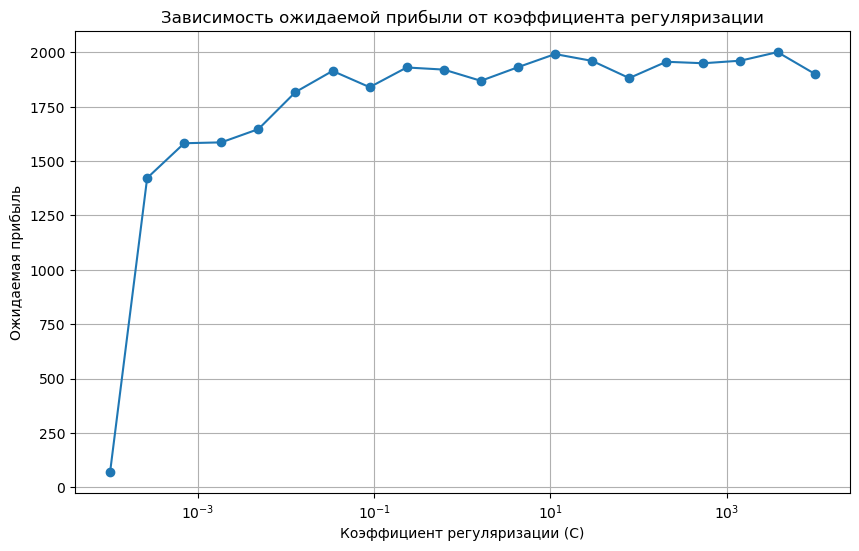

In [51]:
from sklearn.model_selection import GridSearchCV

def calculate_profit(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    profit = (np.random.uniform(0, 20, tp).sum()) - (fp * 2)
    return profit

param_grid = {'classifier__C': np.logspace(-4, 4, 20)}
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='average_precision', n_jobs=-1)
grid_search.fit(X, y)
profits = []
c_values = param_grid['classifier__C']
for C in c_values:
    pipeline.set_params(classifier__C=C)
    profits_fold = []
    for train_index, test_index in cv.split(df):
        X_train_1, X_test_1 = df.iloc[train_index], df.iloc[test_index]
        y_train_1, y_test_1 = y.iloc[train_index], y.iloc[test_index]
        pipeline.fit(X_train_1, y_train_1)
        y_pred_proba = pipeline.predict_proba(X_test_1)[:, 1]

        profit = calculate_profit(y_test_1, y_pred_proba)
        profits_fold.append(profit)
    mean_profit = np.mean(profits_fold)
    profits.append(mean_profit)
best_C = c_values[np.argmax(profits)]
max_profit = np.max(profits)

print(f"Максимальная прибыль: {max_profit}")
print(f"Коэффициент регуляризации при максимальной прибыли: {best_C}")

plt.figure(figsize=(10, 6))
plt.plot(c_values, profits, marker='o')
plt.xscale('log')
plt.xlabel('Коэффициент регуляризации (C)')
plt.ylabel('Ожидаемая прибыль')
plt.title('Зависимость ожидаемой прибыли от коэффициента регуляризации')
plt.grid(True)
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Каждый раз разный, скорее всего, это связано с рандомизированной частью

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Мне кажется, что важнее высокий recall, потому что зачастую людей, которые открывают депозит после телефонного звонка, очень мало, а именно их нам и нужно находить, потому что они приносят прибыль.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [59]:
from sklearn.model_selection import StratifiedKFold

def cross_validate_thresholds(X, y, model, profit_func, thresholds, n_splits=5, random_state=None, shuffle=True):
    profits_by_threshold = {threshold: [] for threshold in thresholds}
    f1_scores_by_threshold = {threshold: [] for threshold in thresholds}
    kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_probs = model.predict_proba(X_test)[:, 1]
        for threshold in thresholds:
            y_pred = (y_probs >= threshold).astype(int)
            tp = np.sum((y_test == 1) & (y_pred == 1))
            fp = np.sum((y_test == 0) & (y_pred == 1))
            profit = profit_func(tp, fp)
            profits_by_threshold[threshold].append(profit)
            f1 = f1_score(y_test, y_pred)
            f1_scores_by_threshold[threshold].append(f1)
    avg_profits = {threshold: np.mean(profits) for threshold, profits in profits_by_threshold.items()}
    avg_f1_scores = {threshold: np.mean(f1s) for threshold, f1s in f1_scores_by_threshold.items()}
    return avg_profits, avg_f1_scores

thresholds = np.arange(0, 1.01, 0.01)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

avg_profits, avg_f1_scores = cross_validate_thresholds(X, y, pipeline, calculate_profit, thresholds, n_splits=5, random_state=42, shuffle=True)
best_threshold = max(avg_profits, key=avg_profits.get)
print(f"Max Profit: {avg_profits[best_threshold]} at Threshold = {best_threshold}")

Max Profit: 0.0 at Threshold = 0.0


Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




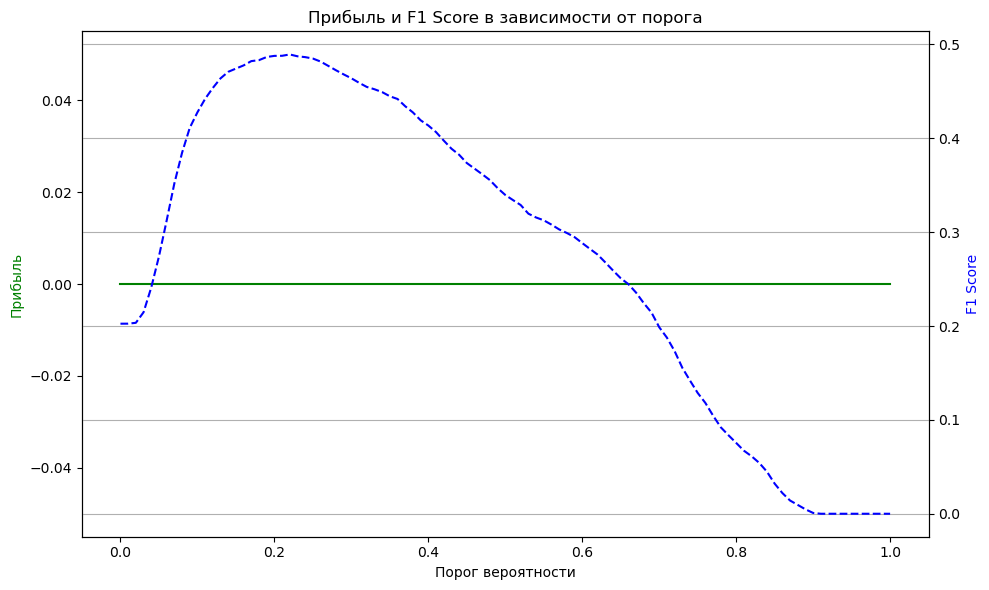

In [61]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
ax1.plot(thresholds, list(avg_profits.values()), 'g-', label='Profit')
ax2.plot(thresholds, list(avg_f1_scores.values()), 'b--', label='F1 Score')

ax1.set_xlabel('Порог вероятности')
ax1.set_ylabel('Прибыль', color='g')
ax2.set_ylabel('F1 Score', color='b')

plt.title('Прибыль и F1 Score в зависимости от порога')
fig.tight_layout()
plt.grid(True)
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ # your answer here

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [63]:
from sklearn.metrics import f1_score
from scipy.stats import ttest_rel

def calculate_profit_per_fold(y_true, y_pred_probs, threshold):
    y_pred = (y_pred_probs >= threshold).astype(int)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return calculate_profit(tp, fp)

def evaluate_profits(X, y, model, threshold, n_splits=5, random_state=None, shuffle=True):
    profits = []
    kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred_probs = model.predict_proba(X_test)[:, 1]
        profit = calculate_profit_per_fold(y_test, y_pred_probs, threshold)
        profits.append(profit)
    return np.array(profits)
    
default_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])
default_profits = evaluate_profits(X, y, default_model, 0.5, n_splits=5, random_state=42, shuffle=True)
optimized_profits = evaluate_profits(X, y, pipeline, best_threshold, n_splits=5, random_state=42, shuffle=True)
t_stat, p_value = ttest_rel(default_profits, optimized_profits)

print(f"Средняя прибыль (дефолтная модель): {default_profits.mean()}, Стандартное отклонение: {default_profits.std()}")
print(f"Средняя прибыль (оптимизированная модель): {optimized_profits.mean()}, Стандартное отклонение: {optimized_profits.std()}")
print(f"t-статистика: {t_stat}, p-value: {p_value}")
if p_value < 0.05:
    print("Статистически значимо")
else:
    print("Не значимо")

Средняя прибыль (дефолтная модель): 0.0, Стандартное отклонение: 0.0
Средняя прибыль (оптимизированная модель): 0.0, Стандартное отклонение: 0.0
t-статистика: nan, p-value: nan
Не значимо


# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ гречневую кашу